In [26]:
from math import log
from random import randint,choices
from utils import classify

In [33]:
class myRandomForestClassifier:
    def __init__(self):
        self.n_estimators = 10
        self.max_features = int(42**0.5)
        self.max_depth = 3
        self.min_samples_split = 2
        self.num_features = 42
        self.feature_cat = [3,6,7,8,9,10,11,13,14,15,16,17,18,21,23,29,30,31,32,33,34,35,36,37,38,39,40]
        self.feature_num = []
        for i in range(42): #ID and is_claim is excluded
            if i not in self.feature_cat:
                self.feature_num.append(i)
                
        self.sample_list = []
        for i in range(1,self.num_features):
            self.sample_list.append(i)
        
    def set_Dict(self,Dict):
        # For acceleration, need to set the dictionary of categorical features' label encoder
        self.Dict = Dict

    def fit(self,X,y):
        self.seq = []
        for i in range(len(X)):
            self.seq.append(i)
        self.tree_ls = self.random_forest(X, y, self.n_estimators, self.max_depth, self.min_samples_split, self.max_features)

    def predict(self,X):
        return self.predict_rf(self.tree_ls,X)

    def log2(self,p):
        return log(p)/log(2)

    def entropy(self,p):
        if p == 0:
            return 0
        elif p == 1:
            return 0
        else:
            return - (p * self.log2(p) + (1 - p) * self.log2(1-p))

    def information_gain(self,left_child, right_child):
        parent = left_child + right_child
        p_parent = parent.count(1) / len(parent) if len(parent) > 0 else 0
        p_left = left_child.count(1) / len(left_child) if len(left_child) > 0 else 0
        p_right = right_child.count(1) / len(right_child) if len(right_child) > 0 else 0
        IG_p = self.entropy(p_parent)
        IG_l = self.entropy(p_left)
        IG_r = self.entropy(p_right)
        return IG_p - len(left_child) / len(parent) * IG_l - len(right_child) / len(parent) * IG_r

    def slices(self,data,indices):
        d = []
        for ind in indices:
            d.append(data[ind])
        return d

    def sampling(self,size):
        length = len(self.sample_list)
        for i in range(length):
            ind1 = randint(0,length-1)
            ind2 = randint(0,length-1)
            temp = self.sample_list[ind1]
            self.sample_list[ind1] = self.sample_list[ind2]
            self.sample_list[ind2] = temp
        ind_start = randint(0,length-7)
        return self.sample_list[ind_start:ind_start+6]

    def data_col(self,data,feature_ind):
        col_data = []
        if feature_ind in self.feature_cat: # +1 because the key value in Dict didn't exclude ID
            max_counter = len(self.Dict[feature_ind+1])
            ls = []
            for i in range(max_counter):
                ls.append(i)
        else:
            ls = set()
            for d in data:
                ls.add(d[feature_ind])

        for d in data:
            col_data.append(d[feature_ind])

        return col_data,ls

    def draw_bootstrap(self,X_train, y_train):
        bootstrap_indices = choices(self.seq,k=len(X_train))
        oob_indices = list(set(self.seq)-set(bootstrap_indices))
        X_bootstrap = self.slices(X_train,bootstrap_indices)
        y_bootstrap = self.slices(y_train,bootstrap_indices)
        X_oob = self.slices(X_train,oob_indices)
        y_oob = self.slices(y_train,oob_indices)
        return X_bootstrap, y_bootstrap, X_oob, y_oob

    def oob_score(self,tree, X_test, y_test):
        mis_label = 0
        for i in range(len(X_test)):
            pred = self.predict_tree(tree, X_test[i])
            if pred != y_test[i]:
                mis_label += 1
        return mis_label / len(X_test)

    def find_split_point(self,X_bootstrap, y_bootstrap, max_features):
        feature_ls = self.sampling(max_features)

        best_info_gain = -999
        node = None
        for feature_ind in feature_ls:
            col_data,unique_col_data = self.data_col(X_bootstrap,feature_ind)
            for split_point in unique_col_data:
                left_child = {'X_bootstrap': [], 'y_bootstrap': []}
                right_child = {'X_bootstrap': [], 'y_bootstrap': []}

                # split children for continuous variables
                if feature_ind in self.feature_num:
                    for i, value in enumerate(col_data):
                        if value <= split_point:
                            left_child['X_bootstrap'].append(X_bootstrap[i])
                            left_child['y_bootstrap'].append(y_bootstrap[i])
                        else:
                            right_child['X_bootstrap'].append(X_bootstrap[i])
                            right_child['y_bootstrap'].append(y_bootstrap[i])

                # split children for categorical variables
                else:
                    for i, value in enumerate(col_data):
                        if value == split_point:
                            left_child['X_bootstrap'].append(X_bootstrap[i])
                            left_child['y_bootstrap'].append(y_bootstrap[i])
                        else:
                            right_child['X_bootstrap'].append(X_bootstrap[i])
                            right_child['y_bootstrap'].append(y_bootstrap[i])

                split_info_gain = self.information_gain(left_child['y_bootstrap'], right_child['y_bootstrap'])
                if split_info_gain > best_info_gain:
                    best_info_gain = split_info_gain
                    node = {'information_gain': split_info_gain,
                            'left_child': left_child,
                            'right_child': right_child,
                            'split_point': split_point,
                            'feature_ind': feature_ind}

        return node

    def terminal_node(self,node):
        y_bootstrap = node['y_bootstrap']
        pred = max(y_bootstrap, key = y_bootstrap.count)
        return pred


    def split_node(self,node, max_features, min_samples_split, max_depth, depth):
        left_child = node['left_child']
        right_child = node['right_child']

        del(node['left_child'])
        del(node['right_child'])

        if len(left_child['y_bootstrap']) == 0 or len(right_child['y_bootstrap']) == 0:
            empty_child = {'y_bootstrap': left_child['y_bootstrap'] + right_child['y_bootstrap']}
            node['left_split'] = self.terminal_node(empty_child)
            node['right_split'] = self.terminal_node(empty_child)
            return

        if depth >= max_depth:
            node['left_split'] = self.terminal_node(left_child)
            node['right_split'] = self.terminal_node(right_child)
            return node

        if len(left_child['X_bootstrap']) <= min_samples_split:
            node['left_split'] = node['right_split'] = self.terminal_node(left_child)
        else:
            node['left_split'] = self.find_split_point(left_child['X_bootstrap'], left_child['y_bootstrap'], max_features)
            self.split_node(node['left_split'], max_features, min_samples_split, max_depth, depth + 1)

        if len(right_child['X_bootstrap']) <= min_samples_split:
            node['right_split'] = node['left_split'] = self.terminal_node(right_child)
        else:
            node['right_split'] = self.find_split_point(right_child['X_bootstrap'], right_child['y_bootstrap'], max_features)
            self.split_node(node['right_split'], max_features, min_samples_split, max_depth, depth + 1)

    def build_tree(self,X_bootstrap, y_bootstrap, max_depth, min_samples_split, max_features):
        root_node = self.find_split_point(X_bootstrap, y_bootstrap, max_features)
        self.split_node(root_node, max_features, min_samples_split, max_depth, 1)
        return root_node

    def random_forest(self,X_train, y_train, n_estimators, max_depth, min_samples_split, max_features):
        tree_ls = list()
        oob_ls = list()
        for i in range(n_estimators):
            X_bootstrap, y_bootstrap, X_oob, y_oob = self.draw_bootstrap(X_train, y_train)
            tree = self.build_tree(X_bootstrap, y_bootstrap, max_depth, min_samples_split,max_features)
            tree_ls.append(tree)
            oob_error = self.oob_score(tree, X_oob, y_oob)
            oob_ls.append(oob_error)
        print("OOB estimate: {:.2f}".format(sum(oob_ls)/len(oob_ls)))# mean
        return tree_ls

    def predict_tree(self,tree, X_test):
        feature_ind = tree['feature_ind']

        if X_test[feature_ind] <= tree['split_point']:
            if type(tree['left_split']) == dict:
                return self.predict_tree(tree['left_split'], X_test)
            else:
                value = tree['left_split']
                return value
        else:
            if type(tree['right_split']) == dict:
                return self.predict_tree(tree['right_split'], X_test)
            else:
                return tree['right_split']

    def predict_rf(self,tree_ls, X_test):
        pred_ls = []
        for i in range(len(X_test)):
            ensemble_preds = [self.predict_tree(tree, X_test[i]) for tree in tree_ls]
            final_pred = max(ensemble_preds, key = ensemble_preds.count)
            pred_ls.append(final_pred)
        return pred_ls

my Random Forest Classifier:
OOB estimate: 0.06
Recall = 0.00%
Precision = 0.00%
Accuracy = 93.59%


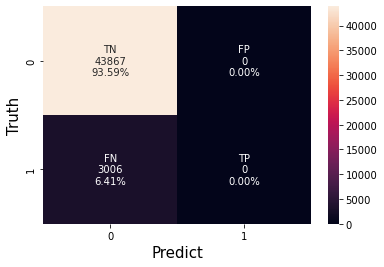

Recall = 0.00%
Precision = 0.00%
Accuracy = 93.67%


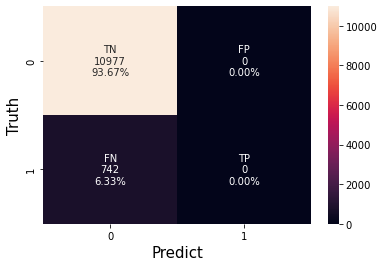

In [34]:
clf = myRandomForestClassifier()
classify(clf,"my Random Forest Classifier")